# Principal Component Analysis

This notebook implements Principal Component Analysis, which is used for multidimensionality reduction by removing the redundant and highly-correlated data and keeping only the most significant data features for further analysis.

Assume we have data consisting of $m$ variables (or features, or attributes, such as bill length, bill depth, flipper length, body mass, etc.) and n observations (or data points, or samples). We form the $m \times n$ ”feature - observation” matrix where variables are listed in the rows and observations in the columns.

As before, we will use the palmer_penguins dataset to demonstrate this.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

penguins = pd.read_csv("Datasets/palmer_penguins.csv")

X = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].to_numpy()
y = penguins.species.to_numpy()

PCA is implemented with the following steps:

1. Standardize (center and scale) the data

To center the data, we subtract the average from each data value. Then to scale, we divide by the standard deviation.

$$
z = \frac{x - \text{mean}}{\text{standard devation}}
$$

Finally, we form the $m\times n$ matrix $A$. 

2. Compute the covariance or correlation matrix

$$
S = \frac{1}{n-1}AA^T
$$

If we are working with only centered data, the above matrix is the covariance matrix, and if we are working with scaled data, then $S$ is the correlation matrix. The entries on the diagonal are the variances (or correlations) for each variable and the off-diagonal entries are the covariances (or correlations) between two variables: positive covariance indicates that the variables are directly related and negative covariance indicates inverse relationship. This matrix is symmetric of size $m \times m$, so its columns are of the same size as the columns of $A$.

In [2]:
A = X - X.mean(axis = 0)

U, sigma, Vt = np.linalg.svd(A, full_matrices=False)

print(f"np.shape(U) = {np.shape(U)}")
print(f"np.shape(sigma) = {np.shape(sigma)}")
print(f"np.shape(Vt) = {np.shape(Vt)} \n")

np.shape(U) = (342, 4)
np.shape(sigma) = (4,)
np.shape(Vt) = (4, 4) 



3.  Find the eigenvalues and the orthonormal eigenvectors of $S$.

These eigenvectors are columns of the matrix $U$ in the singular value decomposition of $A$, up to the factor $n-1$.

$$
A = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{T}
$$

In [3]:
sigma_mat = np.diag(sigma)
print(f"A == U * sigma_mat * Vt: {np.allclose(A, np.dot(U, np.dot(sigma_mat, Vt)))} \n")

A == U * sigma_mat * Vt: True 



4. **Find the principal components.**

We arrange the eigenvalues found in the previous step in the decreasing order. The first principal component $PC_1$ is in the direction of the 1st eigenvector, the second principal component $PC_2$ is in the direction of the 2nd eigenvector, etc.

5. **Reduce the dimension of the data.**

We project data points (i.e., columns of $A$) onto the selected principal components (i.e., several eigenvectors of $S$). The line closest to the data points is in the direction of $PC_1$, etc (”closest” is in the sense of perpendicular least squares).

In addition, the total variance, which is the trace of $S$, is

$$
T = \text{trace}(S) = \frac{\sigma_{1}^{2} + \dots + \sigma_{m}^{2}}{n-1},
$$

and the $i$-th principle component $PC_i$ explains

$$
\frac{\sigma_{i}^{2}/(n-1)}{T} = \frac{\sigma_{i}^{2}}{\sigma_{1}^{2} + \dots + \sigma_{m}^{2}}
$$

of the total variation. We graph the percentages of variation that each $PC_i$ accounts for. Also, the sum of squared distances from the points projected to $PC_i$ to the origin is the eigenvalue for $PC_i$ or the squared singular value $\sigma_{i}^{2}$.

In [4]:
PC1 = Vt.T[:, 0]
PC2 = Vt.T[:, 1]
PC3 = Vt.T[:, 2]
PC4 = Vt.T[:, 3]

W2 = Vt.T[:, :2]
X2D = A.dot(W2)

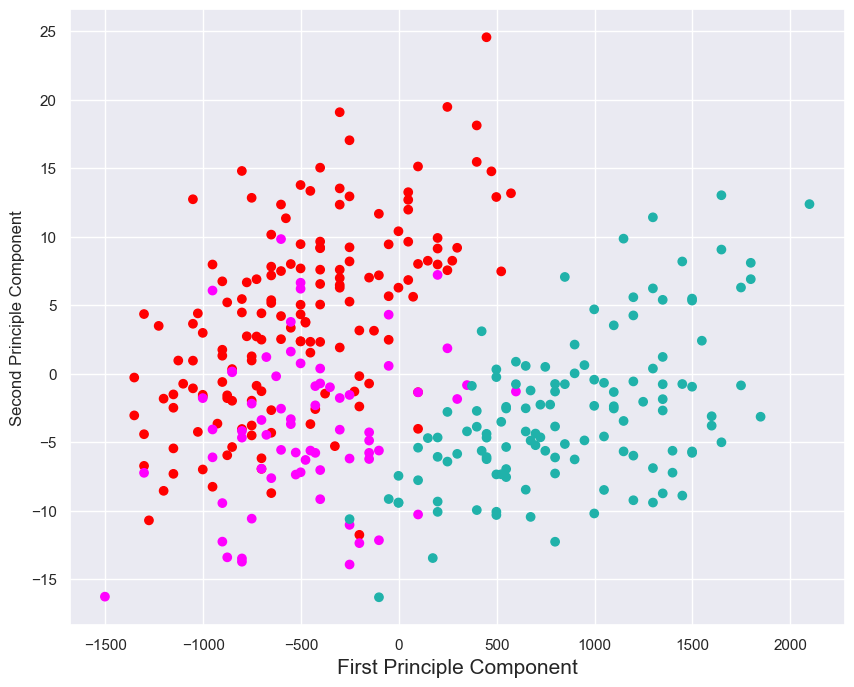

In [5]:
def colors(y):
    if y == "Adelie":
        return "red"
    elif y == "Chinstrap":
        return "magenta"
    else:
        return "lightseagreen"

c = [colors(label) for label in y]

plt.figure(figsize = (10, 8))
plt.scatter(X2D[:, 0], X2D[:, 1], c = c)
plt.xlabel("First Principle Component", fontsize = 15)
plt.ylabel("Second Principle Component")
plt.show()

In [6]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

scaled_X = preprocessing.scale(X)
pca = PCA()
pca.fit(scaled_X)

print(f"pca.explained_variance_ratio_ = {pca.explained_variance_ratio_}")

per_var = np.round(pca.explained_variance_ratio_*100, 2)
print(f"per_var = {per_var} \n")

pca.explained_variance_ratio_ = [0.68843878 0.19312919 0.09130898 0.02712305]
per_var = [68.84 19.31  9.13  2.71] 



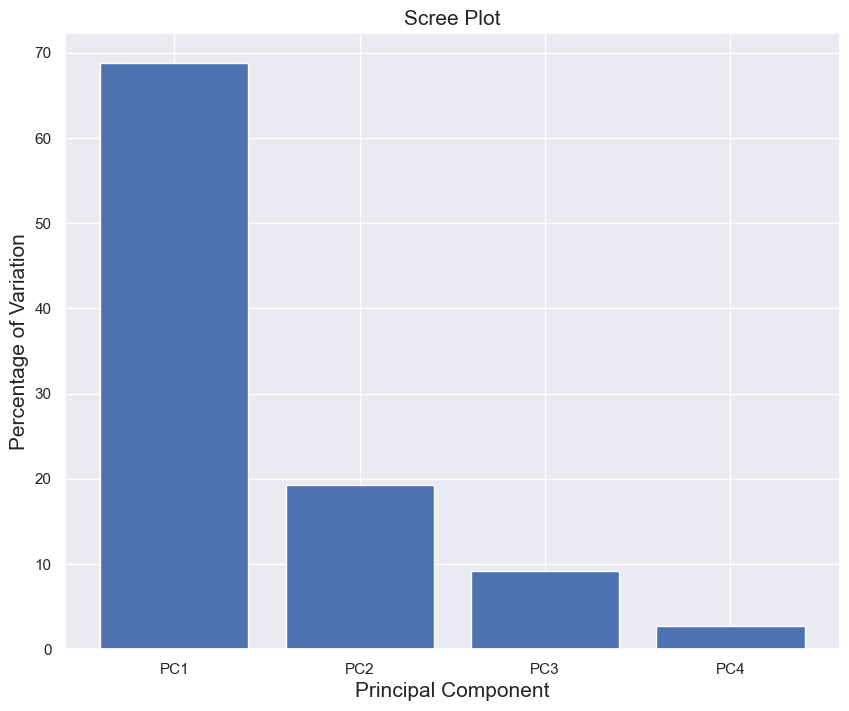

In [7]:
# Create a bar chart for the above array

labels = [f"PC{i}" for i in range(1,5)]

plt.figure(figsize = (10, 8))
plt.bar(x = range(1, 5), height = per_var, tick_label = labels)
plt.xlabel('Principal Component', fontsize = 15)
plt.ylabel('Percentage of Variation', fontsize = 15)
plt.title('Scree Plot', fontsize = 15)
plt.show()

In [8]:
# call function pca.components_ to see how each PC is obtained as a linear combination of the original coordinates

# for example, here PC1 = 0.455 * body_mass_g + 0.597 * bill_length_mm + 0.644 * flipper_length_mm - 0.145 * bill_depth_mm

features = list(set(penguins.columns) - {"species", "island", "sex", "index"})

pd.DataFrame(data = pca.components_, columns = labels, index = features)

,PC1,PC2,PC3,PC4
body_mass_g,0.455250,-0.400335,0.576013,0.548350
bill_length_mm,0.597031,0.797767,0.002282,0.084363
flipper_length_mm,0.644301,-0.418427,-0.232084,-0.596600
bill_depth_mm,-0.145523,0.167986,0.783799,-0.579882


In [9]:
# use pca.transform to see how our data looks like in the new coordinate system

# this will be used later to plot our data in the first two coordinates PC1, PC2

pca_data = pca.transform(scaled_X)

pca_df = pd.DataFrame(pca_data, columns = labels)

pca_df

,PC1,PC2,PC3,PC4
0,-1.843445,0.047702,-0.232794,-0.523903
1,-1.306762,-0.428348,-0.029562,-0.402426
2,-1.369181,-0.154476,0.198672,0.528007
3,-1.878827,-0.002048,-0.618596,0.478378
4,-1.911748,0.829210,-0.686584,0.207428
...,...,...,...,...
337,2.006436,-0.958909,0.364630,-0.174829
338,1.840886,-0.767714,0.229386,-0.002905
339,2.760742,0.288886,-0.428439,-0.240717
340,1.722364,-0.704269,-0.276979,-0.338516


In [10]:
# add to the previous table the labels for each flower

projected_df = pd.concat([pca_df, penguins.species], axis = 1)
projected_df

,PC1,PC2,PC3,PC4,species
0,-1.843445,0.047702,-0.232794,-0.523903,Adelie
1,-1.306762,-0.428348,-0.029562,-0.402426,Adelie
2,-1.369181,-0.154476,0.198672,0.528007,Adelie
3,-1.878827,-0.002048,-0.618596,0.478378,Adelie
4,-1.911748,0.829210,-0.686584,0.207428,Adelie
...,...,...,...,...,...
337,2.006436,-0.958909,0.364630,-0.174829,Gentoo
338,1.840886,-0.767714,0.229386,-0.002905,Gentoo
339,2.760742,0.288886,-0.428439,-0.240717,Gentoo
340,1.722364,-0.704269,-0.276979,-0.338516,Gentoo


In [11]:
projected_df["color"] = c
projected_df

,PC1,PC2,PC3,PC4,species,color
0,-1.843445,0.047702,-0.232794,-0.523903,Adelie,red
1,-1.306762,-0.428348,-0.029562,-0.402426,Adelie,red
2,-1.369181,-0.154476,0.198672,0.528007,Adelie,red
3,-1.878827,-0.002048,-0.618596,0.478378,Adelie,red
4,-1.911748,0.829210,-0.686584,0.207428,Adelie,red
...,...,...,...,...,...,...
337,2.006436,-0.958909,0.364630,-0.174829,Gentoo,lightseagreen
338,1.840886,-0.767714,0.229386,-0.002905,Gentoo,lightseagreen
339,2.760742,0.288886,-0.428439,-0.240717,Gentoo,lightseagreen
340,1.722364,-0.704269,-0.276979,-0.338516,Gentoo,lightseagreen


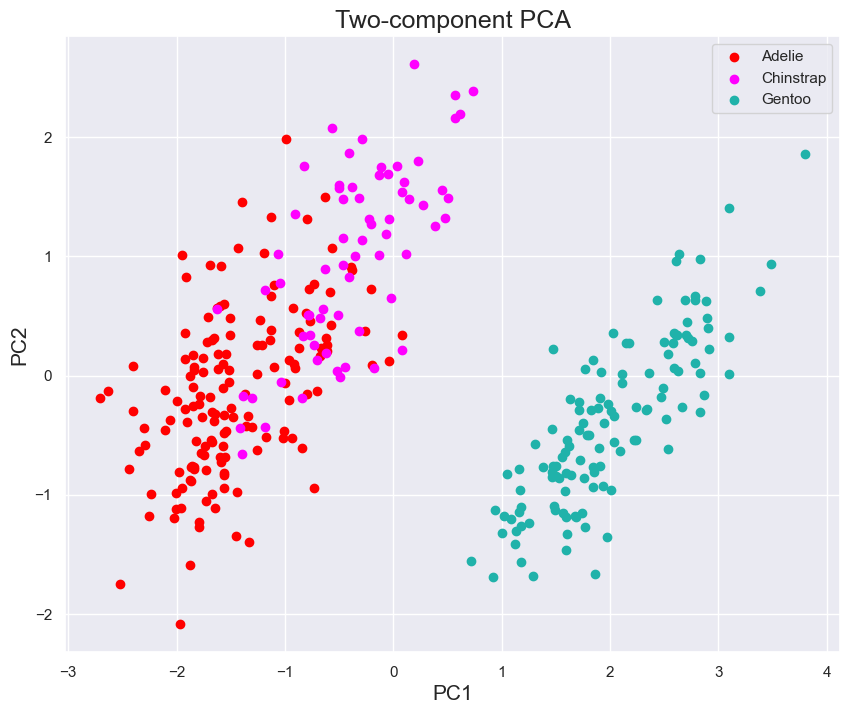

In [12]:
targets = ["Adelie", "Chinstrap", "Gentoo"]
colors = ["red", "magenta", "lightseagreen"]

plt.figure(figsize = (10, 8))

for target, color in zip(targets, colors):
    temp_df = projected_df[projected_df['species'] == target]
    plt.scatter(temp_df["PC1"], temp_df["PC2"], c = color)
    
plt.xlabel('PC1', fontsize = 15)
plt.ylabel('PC2', fontsize = 15)
plt.title('Two-component PCA', fontsize = 18)
plt.legend(targets)
plt.show()

Visually, the Principal Component Analysis seems to have done a much better job of breaking apart overlapping clusters than some of the other grouping algorithms have, especially $k$-means clustering.